In [1]:
import numpy as np
import pandas as pd
# from BERT import bert_embed_text
from tqdm import tqdm
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch_functions as torch_fns
from torchinfo import summary
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import word_wizard as ww
from sklearn.metrics.pairwise import euclidean_distances, pairwise_distances_argmin_min
from pprint import pprint

/Users/johnbergmann/.pyenv/versions/3.8.16/envs/RB_NLP/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/johnbergmann/.pyenv/versions/3.8.16/envs/RB_NLP/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/johnbergmann/.pyenv/versi

In [2]:
articles = pd.read_csv("../data/clean/QuantumComputing_999.csv")
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3330 entries, 0 to 3329
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_index  3330 non-null   int64 
 1   engine         3330 non-null   object
 2   link           3330 non-null   object
 3   source         3330 non-null   object
 4   title          3330 non-null   object
 5   description    3330 non-null   object
 6   body           3330 non-null   object
 7   paragraph      3330 non-null   object
dtypes: int64(1), object(7)
memory usage: 208.2+ KB


In [3]:
articles["article_index"].unique().shape

(329,)

## NLP Pipeline

In [4]:
wizard = ww.WordWizard(df=articles)

In [5]:
wizard.df.head()

,article_index,engine,link,source,title,description,body,paragraph,sentences
0,0,Yahoo,http://www.wwnytv.com/prnewswire/2023/06/15/qu...,WWNY - WNYF Watertown,Quantum Computing Inc. Launches Its First-in-a...,"Beginning today, QCi is accepting orders via i...",QCi Embraces the Advantages of Edge Computing ...,"LEESBURG, Va., June 15, 2023 /PRNewswire/ -- Q...","[LEESBURG, Va., June 15, 2023 /PRNewswire/ -- ..."
1,0,Yahoo,http://www.wwnytv.com/prnewswire/2023/06/15/qu...,WWNY - WNYF Watertown,Quantum Computing Inc. Launches Its First-in-a...,"Beginning today, QCi is accepting orders via i...",QCi Embraces the Advantages of Edge Computing ...,Reservoir computing is a framework for computa...,[Reservoir computing is a framework for comput...
2,0,Yahoo,http://www.wwnytv.com/prnewswire/2023/06/15/qu...,WWNY - WNYF Watertown,Quantum Computing Inc. Launches Its First-in-a...,"Beginning today, QCi is accepting orders via i...",QCi Embraces the Advantages of Edge Computing ...,"Dr. Yuping Huang, QCi Chief Quantum Scientist ...","[Dr. Yuping Huang, QCi Chief Quantum Scientist..."
3,0,Yahoo,http://www.wwnytv.com/prnewswire/2023/06/15/qu...,WWNY - WNYF Watertown,Quantum Computing Inc. Launches Its First-in-a...,"Beginning today, QCi is accepting orders via i...",QCi Embraces the Advantages of Edge Computing ...,QCi's first reservoir computer uses the Compan...,[QCi's first reservoir computer uses the Compa...
4,0,Yahoo,http://www.wwnytv.com/prnewswire/2023/06/15/qu...,WWNY - WNYF Watertown,Quantum Computing Inc. Launches Its First-in-a...,"Beginning today, QCi is accepting orders via i...",QCi Embraces the Advantages of Edge Computing ...,"""The launch of QCi's Reservoir Computer repres...","[""The launch of QCi's Reservoir Computer repre..."


In [6]:
wizard.create_word_embeddings(column="body")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Creating word embeddings for column body:   0%|          | 0/328 [00:00<?, ?it/s]

In [7]:
wizard.cluster_embeddings(column="body")  

In [8]:
wizard.summarize_medoids(column="body")

Creating summaries for medoids of column body:   0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
wizard.find_sentiment(column="body")

Calculating sentiment for column body:   0%|          | 0/328 [00:00<?, ?it/s]

In [14]:
wizard.df.columns

Index(['article_index', 'engine', 'link', 'source', 'title', 'description',
       'body', 'paragraph', 'sentences', 'body_word_embeddings',
       'body_word_embeddings_clusters',
       'body_word_embeddings_clusters_medoids',
       'body_word_embeddings_clusters_medoids_summaries', 'body_sentiment'],
      dtype='object')

In [15]:
pprint(wizard.df.loc[~wizard.df["body_word_embeddings_clusters_medoids_summaries"].isna(), "body_word_embeddings_clusters_medoids_summaries"].tolist()[0])

('The global Quantum Computing Chip market size is projected to reach '
 'multimillion USD by 2030.<n>Superconducting Chip, Topological Chip, Photonic '
 'Chip, Others.<n>Below 30 Qubit Quantum Computer, Qubit Quantum Computer, '
 '50-60 Qubit Quantum Computer, Above Qubit Quantum Computer.')


In [16]:
pprint(wizard.df.loc[~wizard.df["body_word_embeddings_clusters_medoids_summaries"].isna(), "body_word_embeddings_clusters_medoids_summaries"].tolist()[1])

('Quantum Chip Quantum Brilliance has announced the general availability of '
 'Qristal SDK.<n>SDK is an open-source software development kit designed for '
 'researching applications.<n>The company hopes its quantum technology will '
 'prove beneficial in hybrid data centers.')


In [19]:
pprint(wizard.df.loc[~wizard.df["body_word_embeddings_clusters_medoids_summaries"].isna(), "body_word_embeddings_clusters_medoids_summaries"].tolist()[2])

('The Quantum Computing in Chemistry market is anticipated to rise at a '
 'considerable rate during the forecast period, between 2023 and 2028.<n>The '
 'market is growing at a steady rate and with the rising adoption of '
 'strategies by key players, the market is expected to rise over the projected '
 'horizon.<n>The research also provides a market analysis using various '
 "analytical techniques, including Porter's Five Forces Analysis,SWOT "
 'Analysis, and PESTEL Analysis.')


In [20]:
pprint(wizard.df.loc[~wizard.df["body_word_embeddings_clusters_medoids_summaries"].isna(), "body_word_embeddings_clusters_medoids_summaries"].tolist()[3])

('German Chancellor Angela Merkel inaugurated a computer that uses subatomic '
 'particles to make millions of calculations in microseconds.<n>Europe, the '
 'United States and China are locked in competition over who can build and '
 'exploit the most powerful computers.<n>Quantum technology, while still in '
 'its infancy, promises to carry out previously impossible calculations at '
 'record speed.<n>Germany hopes that quantum computing will spur innovation '
 'across industry — from transport and the environment to health.')


In [35]:
pprint(wizard.df.loc[~wizard.df["body_word_embeddings_clusters_medoids_summaries"].isna(), "body_word_embeddings_clusters_medoids_summaries"].tolist()[4]), pprint(wizard.df.loc[~wizard.df["body_word_embeddings_clusters_medoids_summaries"].isna(), "body_sentiment"].tolist()[4])

('Decades of research have yet to yield a machine that can kick off the '
 'promised revolution in computing.<n>Computers that exploit the strange '
 'behaviours of the atomic realm could accelerate drug discovery, crack '
 'encryption, speed up decision-making in financial transactions, improve '
 'machine learning, develop revolutionary materials and even address climate '
 'change.<n>useful computations are possible only on quantum machines with a '
 'huge number of qubits, and those do not yet exist.')
0.0


(None, None)

In [17]:
wizard.df.groupby("body_sentiment")["body_word_embeddings_clusters_medoids_summaries"].count()

body_sentiment
0.0    1
1.0    9
Name: body_word_embeddings_clusters_medoids_summaries, dtype: int64

In [18]:
wizard.df.groupby("engine")["body_sentiment"].mean()

engine
Bing      0.917874
Google    0.948609
Yahoo     0.847769
Name: body_sentiment, dtype: float64

In [ ]:
wizard.df

In [ ]:
wizard.df.head()

In [ ]:
wizard.cluster_embeddings(column="sentences")

In [ ]:
self.df[self.df[column + '_word_embeddings_clusters' + self.MEDOID_SUFFIX] == True]

In [ ]:
wizard.df["sumbag"] = np.nan

In [ ]:
wizard.df["sumbag"].iloc[3] = 3

In [ ]:
wizard.df.loc[wizard.df["sentence_embeddings_clusters_medoids"] == True, "body"].index

In [ ]:
wizard.df.head()

In [ ]:
wizard.find_sentiment(column="paragraph", device="cpu")

In [ ]:
wizard.df.columns

In [ ]:
# Grouping the articles by article_index and finding mean sentiment
wizard.df.groupby("engine")["paragraph_sentiment"].mean()

In [ ]:
# Find top 5 highest average sentiment score for engine
wizard.df.groupby("engine")[["paragraph_sentiment"]].mean()

In [ ]:
pp.pprint(wizard.df.loc[wizard.df["paragraph_sentiment"] == 0, "paragraph"].iloc[0])

In [ ]:
pp.pprint(wizard.df.loc[wizard.df["paragraph_sentiment"] == 0, "paragraph"].iloc[1])

In [ ]:
pp.pprint(wizard.df.loc[wizard.df["paragraph_sentiment"] == 0, "paragraph"].iloc[2])

In [ ]:
wizard.create_word_embeddings(columns=["body"], lean=True) \
      .cluster_embeddings("body")

In [ ]:
(wizard.df["body_word_embeddings_cluster_4_is_medoid"].value_counts())

In [ ]:
wizard.df

In [ ]:
x = np.random.rand(100, 2)
km = KMeans(n_clusters=2)
km.fit(x)

In [ ]:
centers = km.cluster_centers_
centers

In [ ]:
pairwise_distances_argmin_min(centers, x)

In [ ]:
wizard.df.columns

In [ ]:
wizard \
.create_word_embeddings(columns=["body"], lean=True) \
.create_sentence_embeddings(device="cpu") \
.cluster_embeddings("body_word_embeddings")

In [ ]:
wizard.df

In [ ]:
wizard.df["body_word_embeddings"][2]

In [ ]:
df = wizard.df
orgs = df["body_NER"].tolist()

# Get all the unique organizations from the dictionaries in list of lists
orgs = [org for org_list in orgs for org in org_list]

# get unique values of key B-ORG and I-ORG
orgs = set([org["word"] for org in orgs if org["entity"] in ["B-ORG", "I-ORG"]])
orgs

In [ ]:
wizard.create_word_embeddings(columns=["paragraph"], lean=True, device="mps")


In [ ]:
wizard.create_word_embeddings(columns=['body', 'paragraph'], device="mps")

In [ ]:

wizard.create_sentence_embeddings(device="cpu")

In [ ]:
df = wizard.df
df["body_sentence_embeddings"]

### Verify

In [ ]:
articles['para'] = articles['body'].apply(lambda x: x.split('\n\n'))

# make df longer by exploding para
articles = articles.explode('para', ignore_index=False)
articles = articles.reset_index()

In [ ]:
unique_indices = articles[~articles['body'].duplicated()].index.tolist()
unique_indices[0], unique_indices[1]

In [ ]:
unique_indices[1] - unique_indices[0]

In [ ]:
np.tile(np.array([1, 3, 4]), (unique_indices[1] - unique_indices[0], 1))

In [ ]:
articles.loc[0: 33, "body"] = np.array([1, 3, 4])

In [ ]:
articles

In [ ]:
articles.loc[0: 33, "ree"] = np.tile(np.array([1, 3, 4]), (34, 1)).tolist()

In [ ]:
articles

In [ ]:
from nltk.tokenize import sent_tokenize
articles['sent'] = articles['para'].apply(lambda x: sent_tokenize(x))

# average number of sentences per paragraph
articles['sent'].apply(lambda x: len(x)).mean()

In [ ]:
import spacy
roberta_nlp = spacy.load("en_core_web_trf")
tqdm.pandas()

In [ ]:
paragraphs = articles['para'].tolist()
articles["para_NER"] = articles["para"].progress_apply(lambda x: list(roberta_nlp(x).ents))

In [ ]:
set(articles["para_NER"].explode().tolist())

In [ ]:
from SBERT import bert_embed_words

articles['para_embed'] = articles['para'].apply(lambda x: bert_embed_words(x))

In [ ]:
df["body_sentence_embeddings"][0]

In [ ]:
articles["para_embed"][0].round(4) == df["body_sentence_embeddings"][0].round(4)

In [ ]:
from nltk.tokenize import sent_tokenize

articles["paragraph"] = articles["body"].apply(lambda x: x.split("\n\n"))

articles = articles.explode("paragraph", ignore_index=False)
articles = articles.reset_index(names="para_index")
articles["sentences"] = articles["paragraph"].apply(lambda x: sent_tokenize(x))

In [ ]:
articles["sentences"].iloc[42]

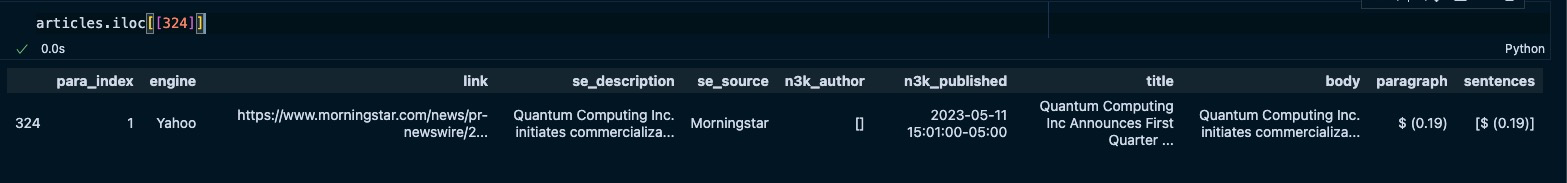

In [ ]:
lean = lean_wizard.create_sentence_embeddings()

In [ ]:
lean["body", "body_sentence_embeddings"].head()

In [ ]:
bulky[["title", "body", "body_embedded", "title_embedded"]].head()

In [ ]:
# Setup device agnostic code (Chooses NVIDIA or Metal backend if available, otherwise defaults to CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    
else:
    device = torch.device("cpu")
device

In [ ]:
articles.head(3)

In [ ]:
articles.set_index(["link", ""], inplace=True)

### Uncomment below cell when running notebook for the first time

In [ ]:
#An alternative would be to try summarizing by paragraph (we shall do that soon)

# articles['body_embedding'] = None
# for i in tqdm(range(len(articles))):
#     try:
#         articles.at[i,'body_embedding'] = bert_embed_text(articles.at[i,'body']).tolist()
#     except:
#         articles.at[i,'body_embedding'] = []

# articles.to_parquet('../data/misc/quant_embed.gzip',compression='gzip', index=False)

In [ ]:
bert_embed_text = pd.read_parquet('../data/misc/quant_embed.gzip')
sentence_embeddings_df = pd.DataFrame(bert_embed_text['body_embedding'].tolist(), index=bert_embed_text.index).dropna().values
sentence_embeddings = MinMaxScaler().fit_transform(np.array(sentence_embeddings_df))

In [ ]:
bert_embed_text

In [ ]:
data = torch.from_numpy(sentence_embeddings).type(torch.float32)

In [ ]:
data.shape, data.dtype, data.max(), data.min()

In [ ]:
# Setup hyperparameters
NUM_EPOCHS = 200
BATCH_SIZE = 16
INPUT_SHAPE = 768
HIDDEN_UNITS = list([256, 16]) # For some reason fails when just doing [] kekw
OUTPUT_SHAPE = 768
LEARNING_RATE = 0.0002 #Default adam is 1e-3
DROPOUT = 0.2

In [ ]:
# Setup DataLoaders
from os import cpu_count
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [ ]:
next(iter(dataloader)).shape, len(dataloader)

In [ ]:
# Instantiate model
model = torch_fns.Autoencoder(INPUT_SHAPE, HIDDEN_UNITS, OUTPUT_SHAPE, DROPOUT)

In [ ]:
# Print a summary using torchinfo
summary(model=model, 
        input_size=(BATCH_SIZE, INPUT_SHAPE),
        # col_names=["input_size"],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

In [ ]:
# Set loss and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Start training with help from torch_functions.py
results = torch_fns.train(
    model=model,
    dataloader=dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device,
)


In [ ]:
torch_fns.plot_loss_curves(results)

In [ ]:
with torch.inference_mode():
    model = model.to(device)
    data = data.to(device)
    encoded = model.encode(data)
    decoded = model.decode(encoded)
    error = loss_fn(decoded, data).item()
    enc = encoded.cpu().numpy()
    dec = decoded.cpu().numpy()
    data = data.cpu().numpy()

print(f'Root mean squared error: {np.sqrt(error):.4f}')

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

ax1.scatter(sentence_embeddings[:,0], sentence_embeddings[:,1])
ax1.set_title('Original')

ax2.scatter(enc[:,0], enc[:,1])
ax2.set_title('Encoded')

ax3.scatter(dec[:,0], dec[:,1])
ax3.set_title('Decoded')

plt.show()

In [ ]:
data.shape, enc.shape

In [ ]:
# Remove outliers from encoded data using iqr using numpy
def remove_outliers_iqr(data, iqr_range=1.5):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr_range * iqr)
    upper_bound = q3 + (iqr_range * iqr)
    return data[(data > lower_bound) & (data < upper_bound)]

enc = remove_outliers_iqr(enc)
enc.shape

In [ ]:
# Perform clustering
n_clusters = 4  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(enc)

# Calculate cluster means
cluster_centers = kmeans.cluster_centers_

# Create scatter plot
plt.figure(figsize=(8, 6))
for cluster_label in range(n_clusters):
    cluster_points = enc[cluster_labels == cluster_label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_label + 1}')

# Add legend
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='o', s=150, c='black', edgecolors='white', label='Cluster Mean')
plt.legend()

# Show the plot
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Clustering of Dimensionality-Reduced Embeddings')
plt.show()


In [ ]:
##Dynamic retrival of no of clusters
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
best_clusters = 0 # best cluster number which you will get
previous_silh_avg = 0.0
for n_clusters in range(2, 10):
    clusterer = KMeans(n_clusters, init="k-means++", n_init="auto", random_state=42)
    cluster_labels = clusterer.fit_predict(iqr)
    silhouette_avg = silhouette_score(enc, cluster_labels, sample_size=3000)
    if silhouette_avg > previous_silh_avg:
        previous_silh_avg = silhouette_avg
        best_clusters = n_clusters
print("No of Clusters:", best_clusters)

##K-Means Implementation
num_clusters = best_clusters  
km = KMeans(n_clusters=num_clusters, init="k-means++", n_init="auto", random_state=42)  
km.fit(iqr)  
clusters = km.labels_.tolist()  

In [ ]:
# Plot Clusters

plt.scatter(enc[:,0], enc[:,1], c=clusters, s=50, cmap='viridis')